# Install ASE


In [1]:
!pip install ase

# Load Machinery


In [2]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as E:
    pass
    
if os.path.exists('/content/drive'):
  pathtofiles='/content/drive/Shareddrives/Tenacidad_Zr-ZrO2/'
else:
  pathtofiles=os.getcwd()
if pathtofiles is not os.getcwd():
  os.chdir(pathtofiles)

# load ASE 

In [3]:
import sys

In [4]:
sys.path.insert(0, '/data/git/ase/')

In [5]:
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.build import surface, make_supercell
from ase.build import bulk, hcp10m10, hcp0001
from ase.build import stack
from ase import Atoms
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
import numpy as np

In [6]:
zro2 = read_vasp('Structure/POSCAR')
Zr = read_vasp('Structure/mp-131_Zr/POSCAR')

In [7]:
def plotviews(atoms_object,
              rotation1='-90x',
              rotation2='-90x, 45y',
              rotation3='0x'):
  fig = plt.figure()
  ax1 = fig.add_axes((0.1,0.1, 0.3,0.8))
  ax2 = fig.add_axes((0.3,0.1, 0.3,0.8))
  ax3 = fig.add_axes((0.6,0.1, 0.3,0.8))
  plot_atoms(atoms_object,rotation=rotation1, ax=ax1)
  plot_atoms(atoms_object,rotation=rotation2, ax=ax2)
  plot_atoms(atoms_object,rotation=rotation3,ax=ax3)
  return ax1, ax2, ax3

# Objetivo

lo primero que quiero hacer es reconstruir la interfaz de paula:

In [8]:
intf=read_vasp('Interfaces/POSCAR_primero.vasp')

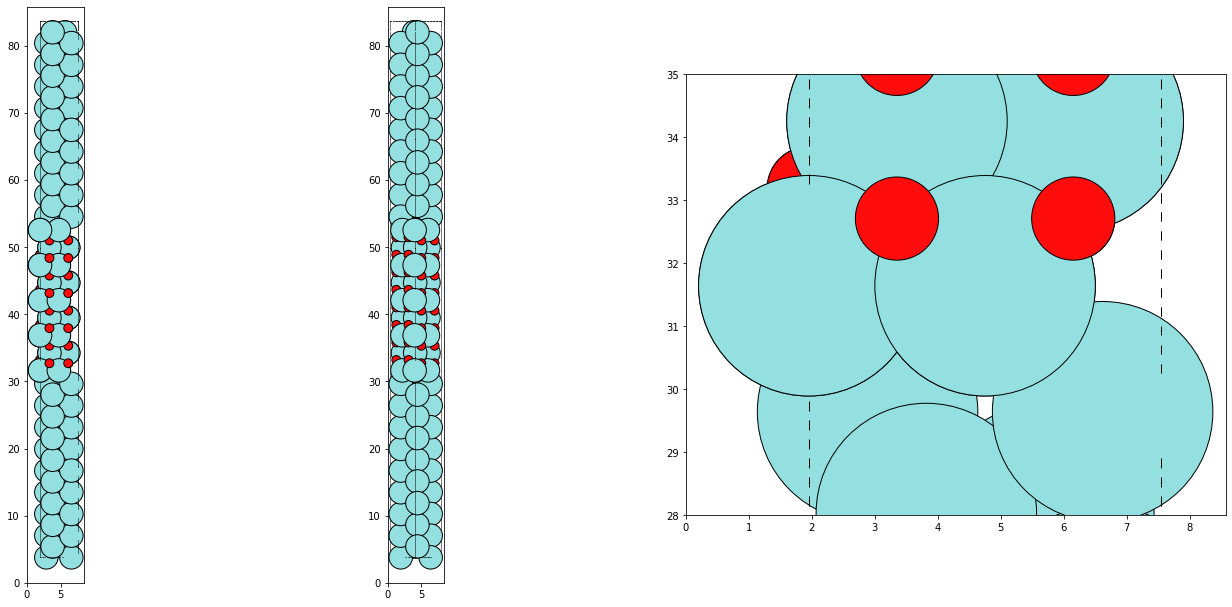

In [9]:
ax1, ax2, ax3 = plotviews(intf, rotation3='-90x')
ax3.set_ylim([28,35])
fig = plt.gcf()

In [10]:
intf.get_global_number_of_atoms()

170

In [11]:
intf.cell

Cell([5.59679985, 5.1479001, 79.84536528])

- observamos que con esos parámetros de red la ZrO<sub>2</sub> está muy comprimida (casi el 30%, hay dos celdas en el slab de óxido)
- observamos que la terminación de la zr debe ser O(valle) , mientras que la que está ahí calculada es Zr.
- a demás hay demasiados átomos!

respecto de esa última observación, tomamos en VESTA la siguiente estructura:

In [12]:
intf_red = read_vasp('Interfaces/POSCAR_reducido.vasp')

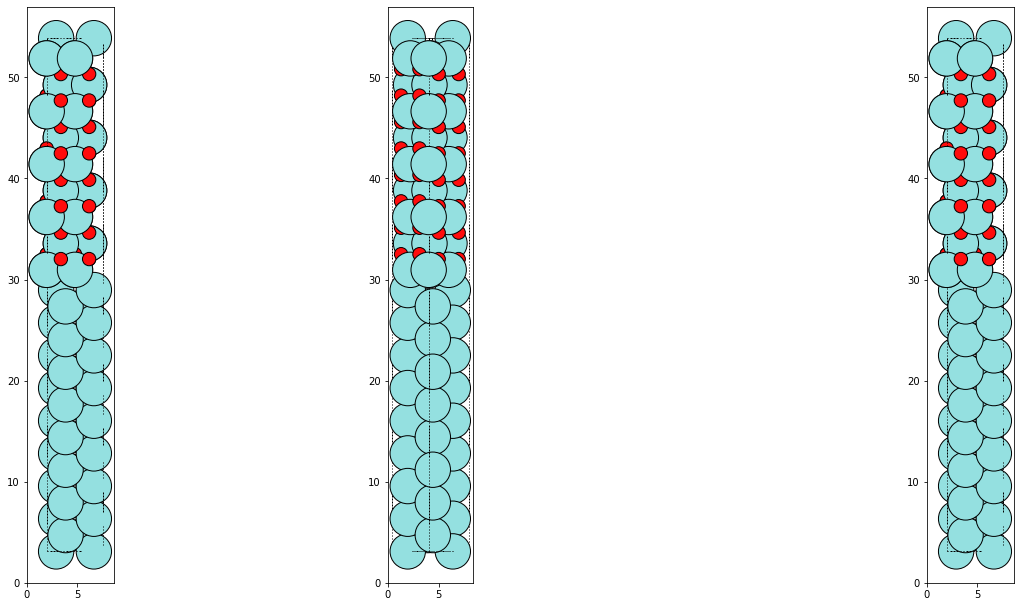

In [13]:
ax1, ax2, ax3 = plotviews(intf_red, rotation3='-90x')

In [14]:
asym_zro2111 = surface(zro2,[0,0,1],4,vacuum=6.0)

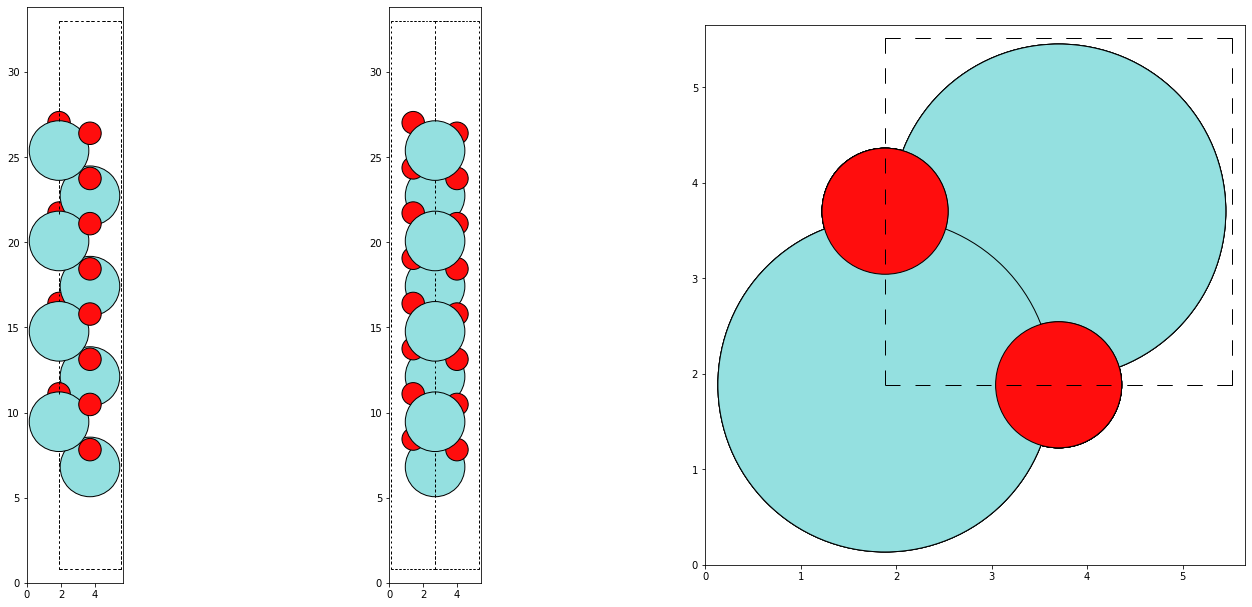

In [15]:
ax1, ax2, ax3 = plotviews(asym_zro2111)

# Superficies

## ZrO2

tratamos de hacer las superficie que a paula le dió mas estable

primero genero la superficie de ZrO<sub>2</sub>

para tener la superficie mas estable y simétrica, hay que sacar algunos átmos:
- los oxígenos de la ceresta
- los zr de la tapa de abajo

In [16]:
all_positions = asym_zro2111.positions
poper = np.where(all_positions[:,2]<all_positions[:,2].min()+0.1)
new_positions = all_positions[all_positions[:,2]>all_positions[:,2].min()+0.1]
all_symbols = asym_zro2111.get_chemical_symbols()
new_symbols = np.delete(all_symbols, poper)
new_ZrO2 = Atoms(new_symbols, positions=new_positions, cell = asym_zro2111.cell)
all_positions = new_ZrO2.get_positions()
all_symbols = new_ZrO2.get_chemical_symbols()
poper = np.where(all_positions[:,2]<all_positions[:,2].min()+0.01)
popper = np.hstack(( poper, np.where(all_positions[:,2]>all_positions[:,2].max()-0.01)))
new_positions = np.delete( all_positions, popper,axis=0)
new_symbols = np.delete(all_symbols, popper)

newer_zro2=Atoms(new_symbols, new_positions, cell=new_ZrO2.cell)

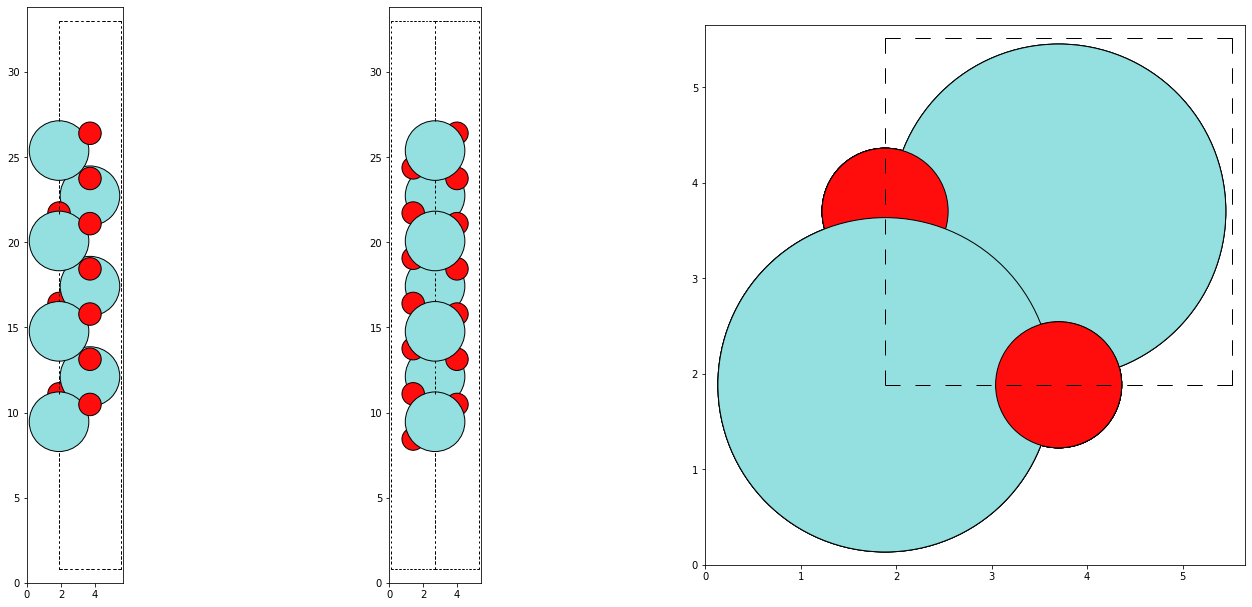

In [17]:
ax1, ax2, ax3 = plotviews(newer_zro2, )

In [18]:
oterm_zro2111x2 = make_supercell(newer_zro2, [[2,0,0],[0,2,0],[0,0,1]])

In [19]:
oterm_zro2111x2.get_chemical_formula()

'O56Zr28'

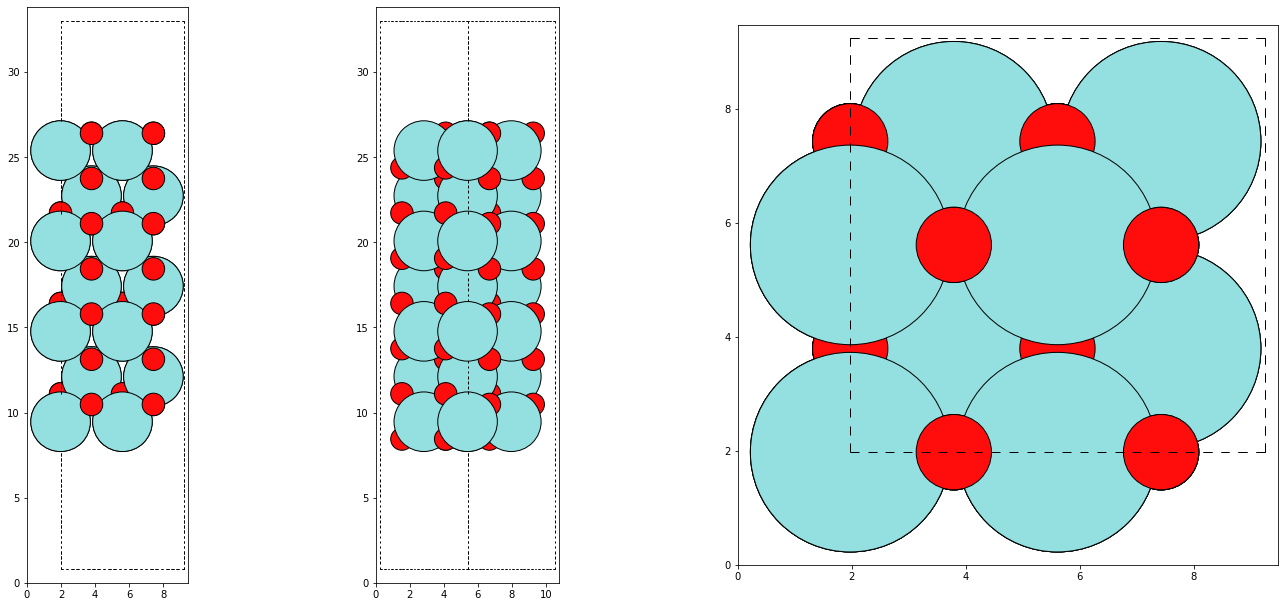

In [20]:
ax1, ax2, ax3 = plotviews(oterm_zro2111x2)

In [21]:
ZrHCP0001 = hcp0001('Zr',[2,2,7], a=3.2313, c=5.1479, vacuum=0, orthogonal=True )

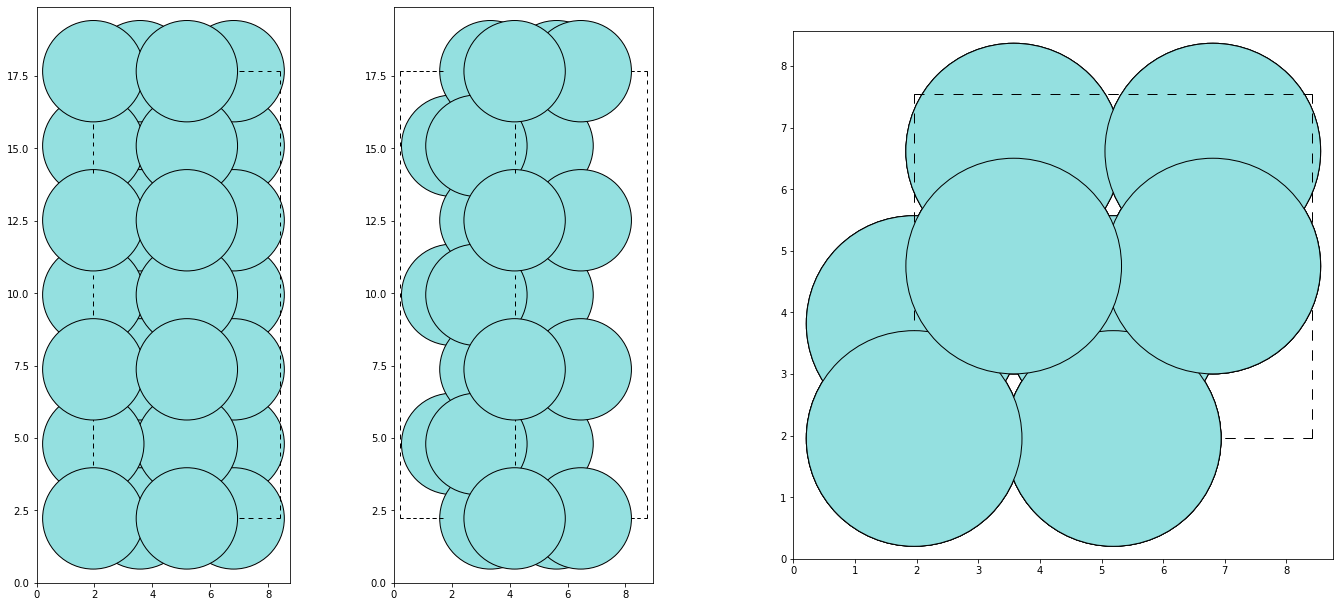

In [22]:
ax1, ax2, ax3 = plotviews(ZrHCP0001)

In [23]:
intfLayer_001hcp_001tet = stack(ZrHCP0001, oterm_zro2111x2, distance=2, maxstrain=3, )

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 224
         Function evaluations: 367


(<Axes:>, <Axes:>, <Axes:>)

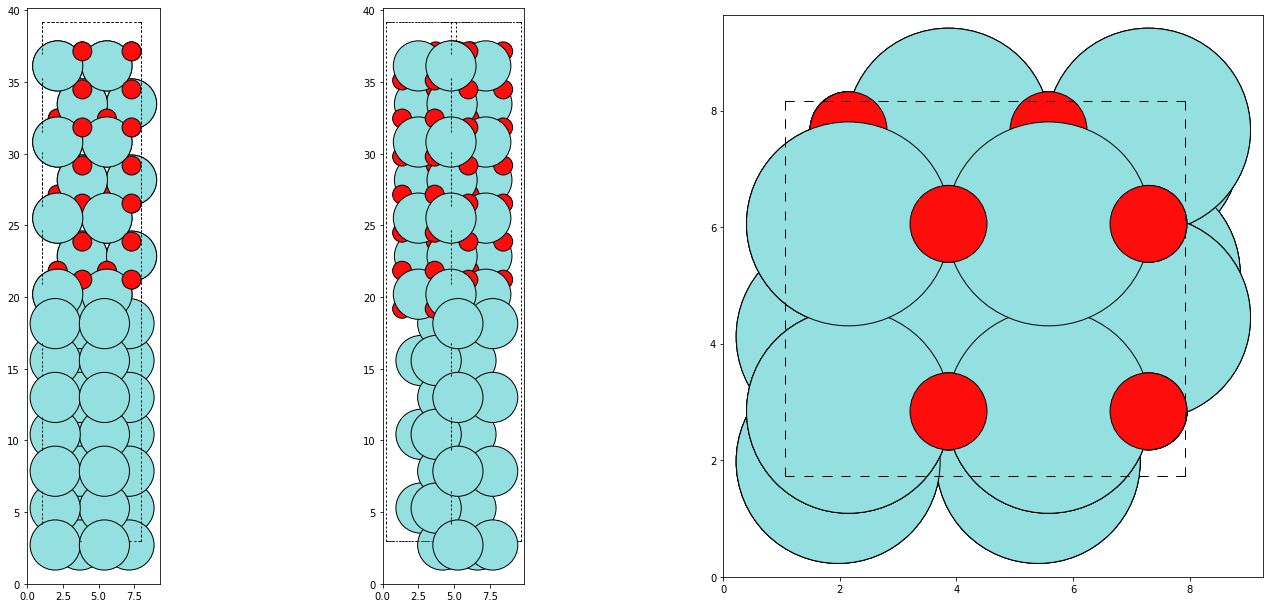

In [24]:
plotviews(intfLayer_001hcp_001tet)

In [25]:
intfLayer_001hcp_001tet.write('ZrO2_Oterm_001_Zrhcp_001.vasp', format='vasp')

# Zr($ 1 0 \bar{1} 0 $)

In [26]:
ZrHCP1010 = hcp10m10('Zr',[1,2,10], a = 3.2313, c=5.1479, vacuum = 0.0)

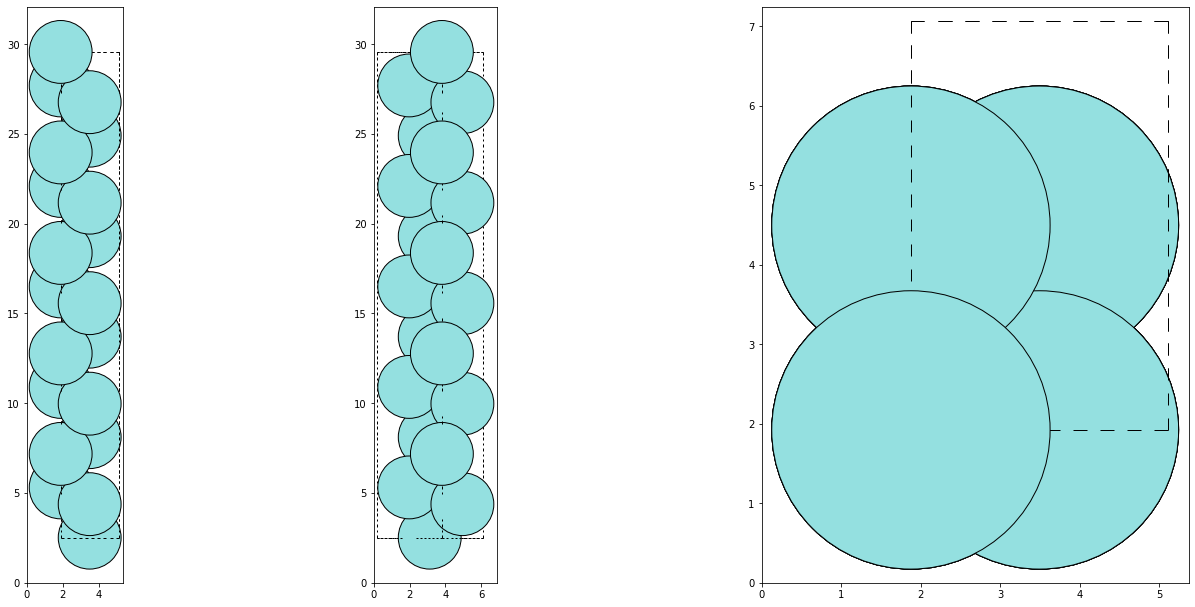

In [27]:
ax1, ax2, ax3 = plotviews(ZrHCP1010)

# Superficies con terminacion con ASE

In [32]:
from importlib.machinery import SourceFileLoader

In [33]:
from ase.build.surfaces_with_termination import surfaces_with_termination, translate_lattice

In [41]:
sft = SourceFileLoader('sfc', '/data/git/ase/ase/build/surfaces_with_termination.py').load_module()

In [42]:
ZrO2001Oterm = sft.surfaces_with_termination(zro2, [0,0,1],layers=4, vacuum=10., termination='O',verbose=True, symmetric=True)
[write_vasp(f'ZrO2001_1x1_{i}.vasp', thisone, sort=True, direct=True) for i, thisone in enumerate(ZrO2001Oterm)]

([4], ['Zr']) ([20], ['O'])
([3], ['O']) ([18], ['O'])
([5], ['Zr']) ([21], ['O'])
([2], ['O']) ([19], ['O'])


[None, None, None, None]

In [44]:
ZrO2001Zrterm = sft.surfaces_with_termination(zro2, [0,0,1], 4, vacuum=10., termination='Zr')

In [45]:
ZrO2001Oterm

[Atoms(symbols='O4ZrO4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 40.22092905883963]),
 Atoms(symbols='O4Zr2O4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 40.61383599482303]),
 Atoms(symbols='O4ZrO4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 40.22092905883963]),
 Atoms(symbols='O4Zr2O4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 40.613835994823035])]

In [46]:
ZrO2001Zrterm

[Atoms(symbols='O4Zr2O4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 40.22092905883963]),
 Atoms(symbols='O4Zr2O4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 40.22092905883963])]

[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

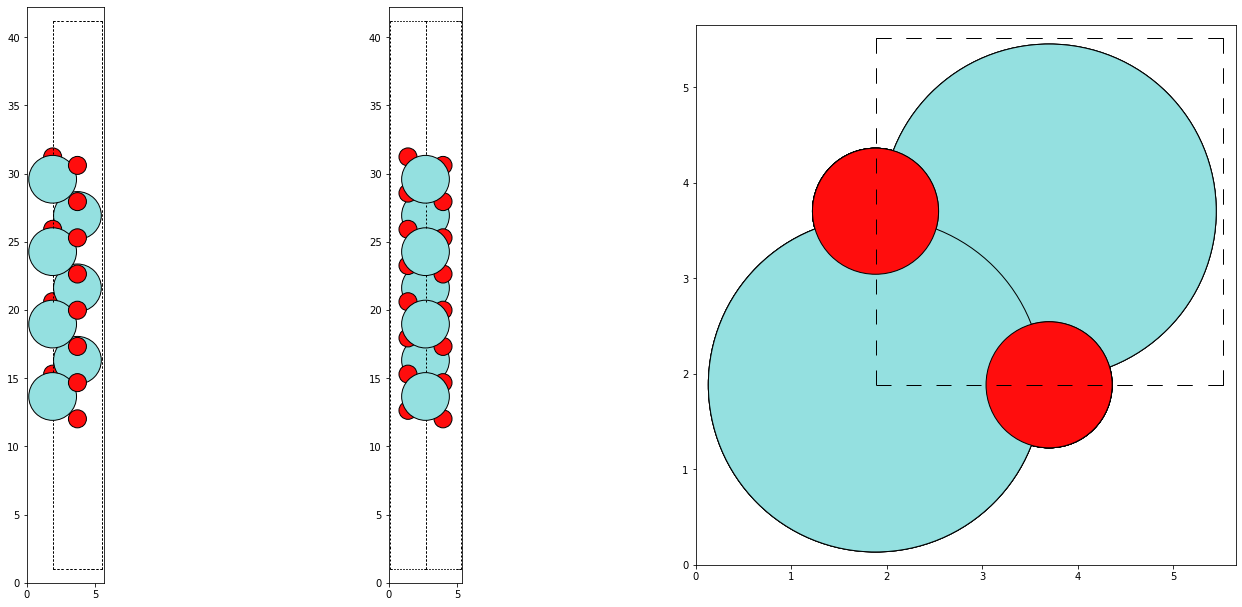

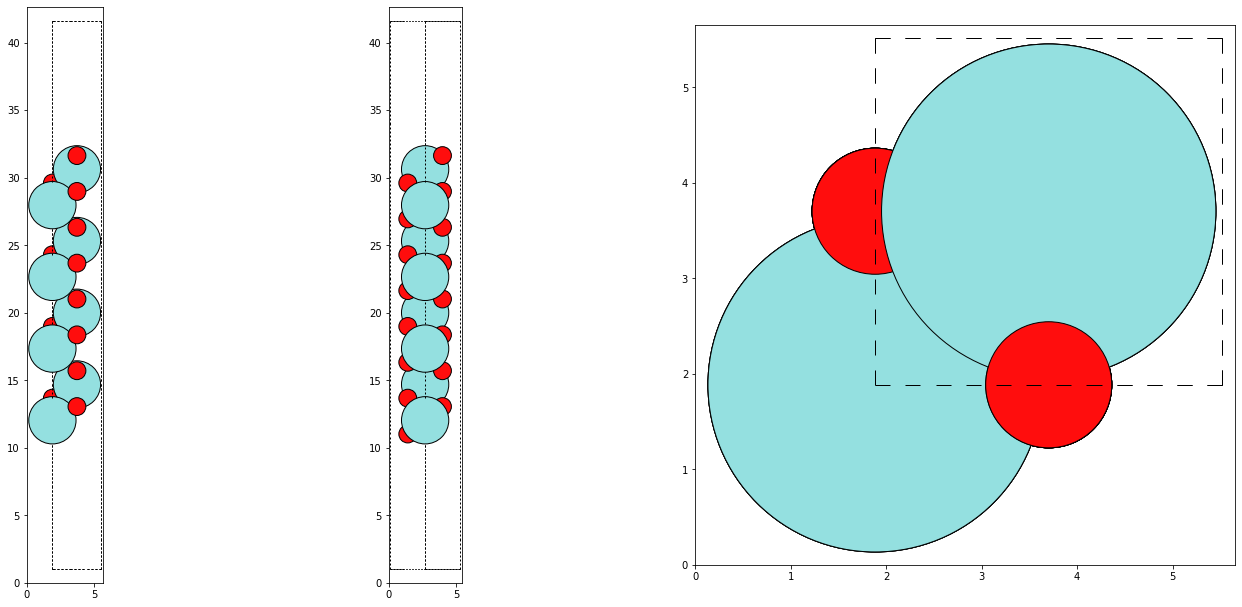

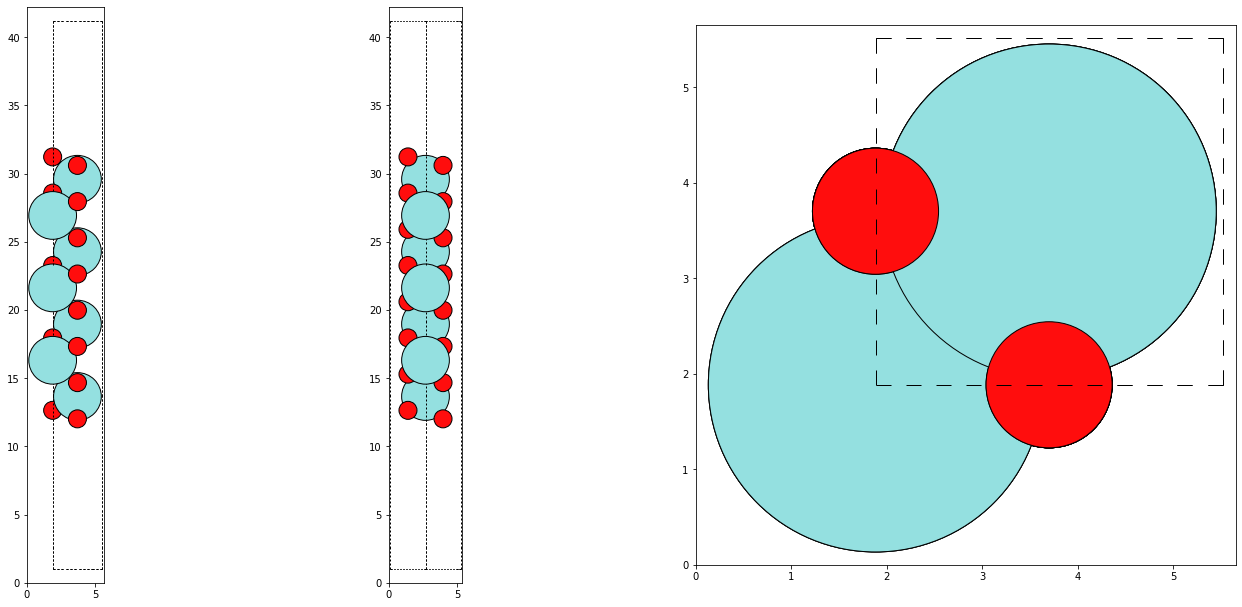

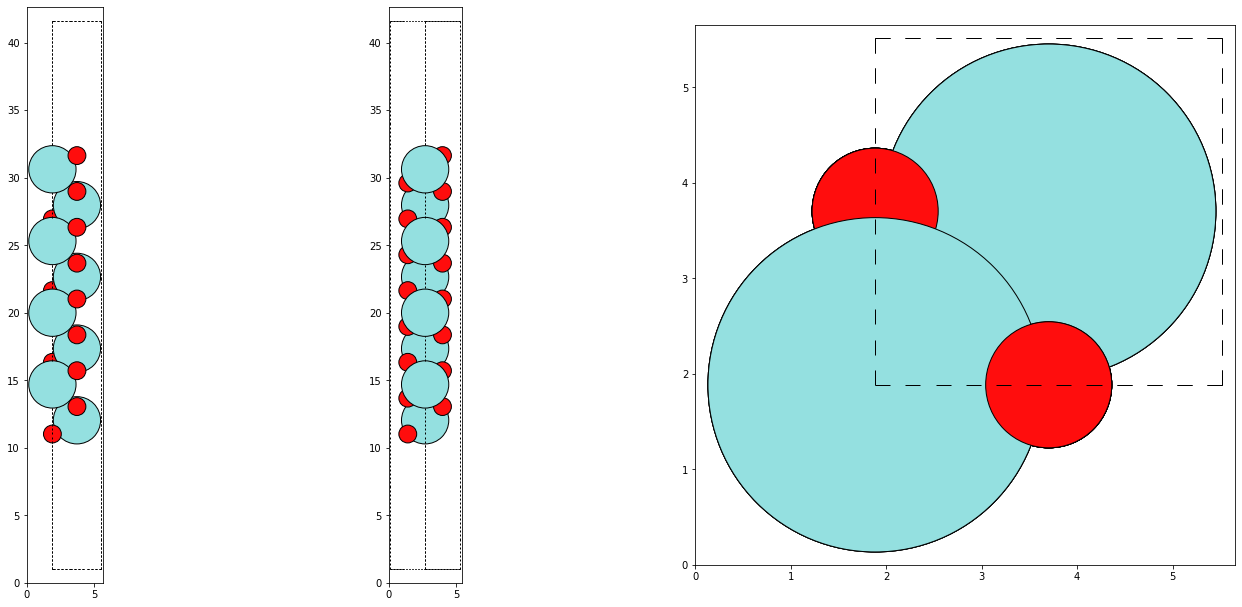

In [47]:
[ plotviews(this) for this in ZrO2001Oterm]

evidentemente arma una y va sacando las capas del otro lado, pero viendo el source code, solo chequea la capa superior! habría que tocar el código para poder hacer superficies simétricas

In [249]:
ZrO2001_2x2 = [make_supercell(ZrO2001Oterm[i],[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True) for i in range(len(ZrO2001Oterm))]
translate = [this.translate([this[0].x]) for this in ZrO2001_2x2]
[this.write(f'ZrO2001_2x2_{i}.vasp',sort=True, direct=True, format='vasp') for i,this in enumerate(ZrO2001_2x2)]

[None, None, None, None]

[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

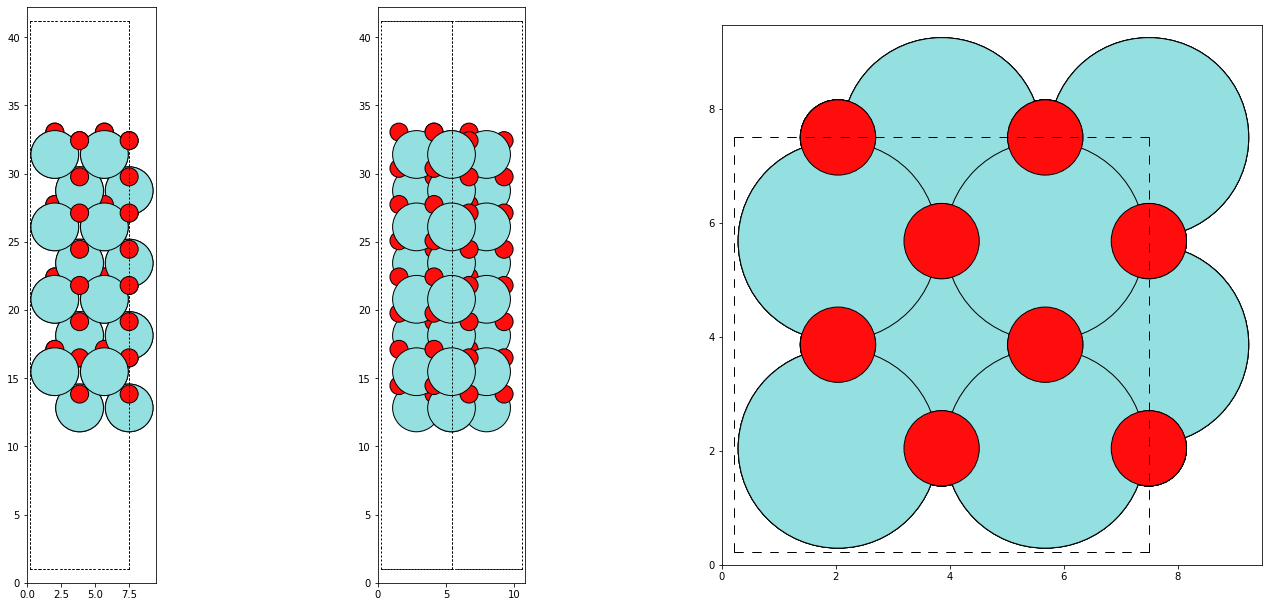

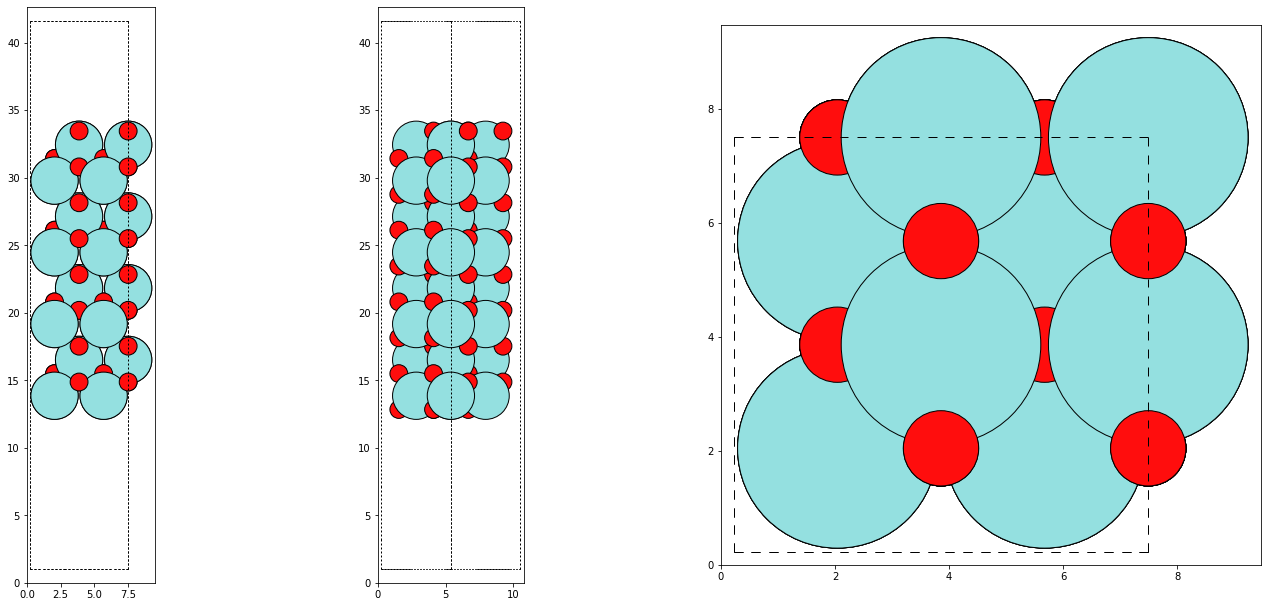

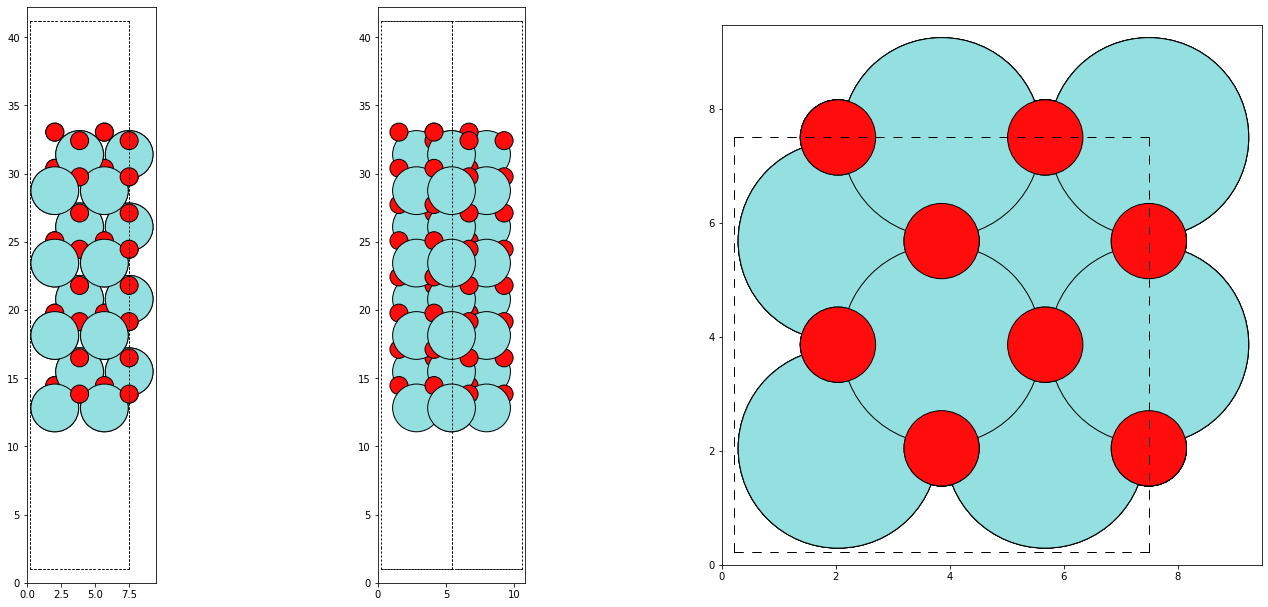

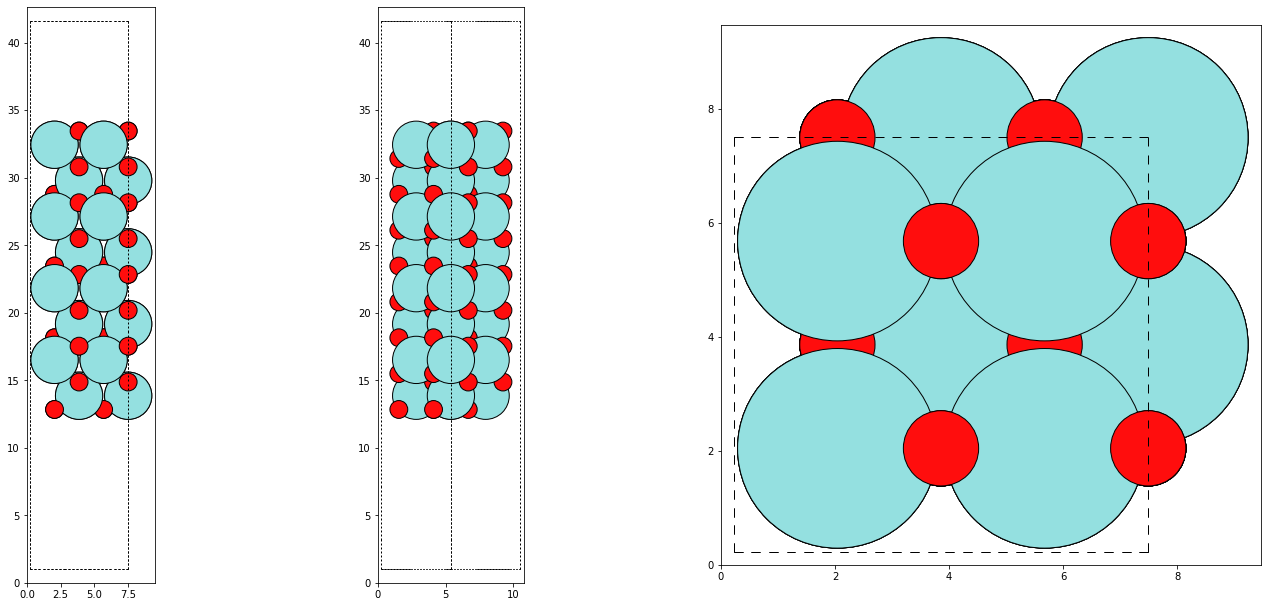

In [250]:
[ plotviews(this) for this in ZrO2001_2x2]

la que corresponde con el modelo de Paula es la última, pero para que quede igual hay que hacerle una trasación todavía:

In [ ]:
intfLayer = stack(ZrHCP1010, oterm_zro2111x2, distance=2, maxstrain=3)

Optimization terminated successfully.
         Current function value: 0.000147
         Iterations: 173
         Function evaluations: 293


In [ ]:
new_positions = ZrHCP1010.get_scaled_positions()+np.array([0,0.1,0])

In [ ]:
ZrHCP1010.set_scaled_positions(new_positions)

In [ ]:
intfLayer

Atoms(symbols='O28Zr34', pbc=[True, True, False], cell=[5.24984899035417, 4.391049495177086, 0.01478345280688842], tags=...)

In [ ]:
intfLayer.get_global_number_of_atoms()

62

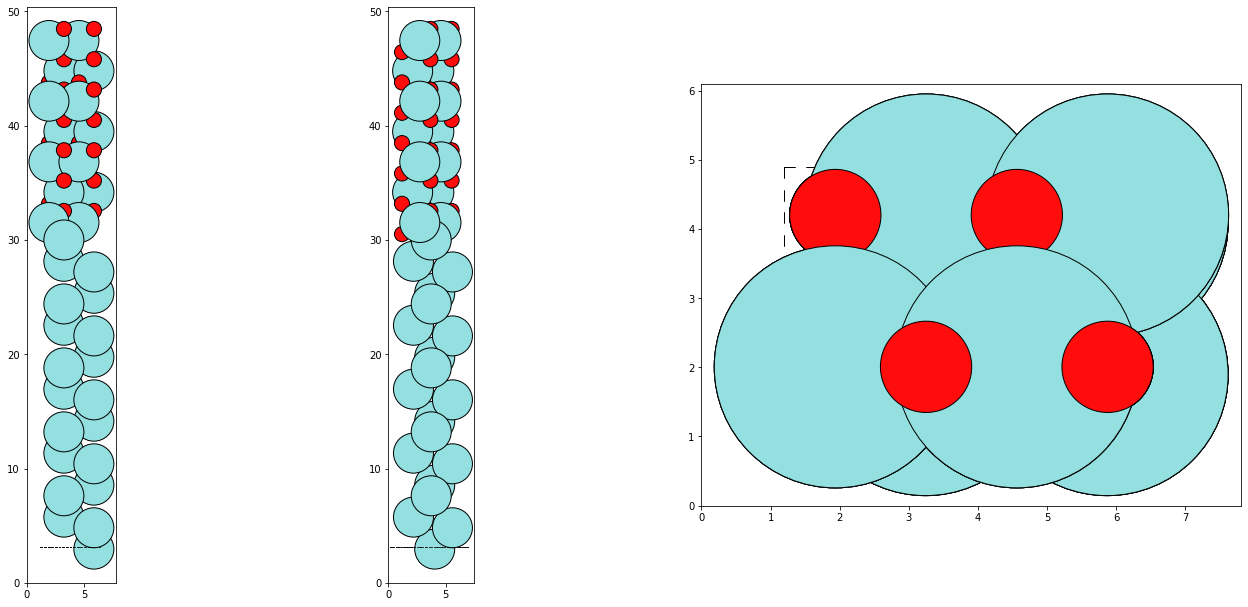

In [ ]:
ax1, ax2, ax3 = plotviews(intfLayer)

In [ ]:
from ase.io import write

In [ ]:
write('CandidateInterface001_1010hcp.vasp', intfLayer, format='vasp')

In [ ]:
write('Interfaces/Layer_ZrO2.vasp', LayerZrO2)

In [ ]:
write('Interfaces/Layer_Zr1010.vasp', LayerZr1010)

Treated in vesta, can see a small probable coincidence at 2x4:
![coincidence]('Interfaces/Layer_Zr1010_coincidence.tiff')

In [ ]:
oterm_zro2111x2 = make_supercell(newer_zro2, [[4,0,0],[0,2,0],[0,0,1]])
Zr1010 = hcp10m10('Zr', [4,2,4], a=3.2313, c=5.1479, vacuum = 0.0 )

In [ ]:
Interface = stack(Zr1010, oterm_zro2111x2,maxstrain=2, distance=2 )

In [ ]:
ax1, ax2,ax3 = plotviews(Interface)

In [ ]:
Interface.get_global_number_of_atoms()

In [ ]:
1/np.sqrt(26)

In [ ]:
5/np.sqrt(26)

# Stack

In [ ]:
STACKED = stack(oterm_zro2111x2, ZrHCP1010,maxstrain=1.0, distance=5.0)

NameError: ignored

In [ ]:
view(STACKED)

In [ ]:
STACKED.__dict__.keys()

In [ ]:
STACKED.__dict__['_cellobj']

In [ ]:
STACKED.cell

In [ ]:
ZrO2_super.cell

In [ ]:
ZrHCP1010.cell

In [ ]:
STACKED.get_global_number_of_atoms()

In [ ]:
view(ZrHCP1010)

In [ ]:
Zr.cell